# Guided Project
### Answering Business Questions using SQL

## Introduction and Schema Diagram

In this guided project, we're going to practice using our SQL skills to answer business questions. In each step, we'll give you a task, and you'll need to:

* Write a SQL query to extract the relevant data
* Create plots where necessary to visualize the data
* Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

We'll continue to use the Chinook database that we've used in earlier missions of this course. The Chinook database is provided as a SQLite database file called `chinook.db`. A copy of the database schema is below - you'll need to come back to this step often to consult the schema as you write your queries.

![https://s3.amazonaws.com/dq-content/191/chinook-schema.svg](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

It's worth remembering that our database retains 'state', so if we run a query with a `CREATE` or `DROP` twice, the query will fail. We should have the skills to get ourselves untangled from these situations, but if you have trouble, or if you manage to lock your database, we have provided a `chinook-unmodified.db` file that you can copy over the `chinook.db` to restore it back to its initial state (see [this blog post on how to run shell commands within a Jupyter notebook](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/#17executingshellcommands)).

In [93]:
!ls *.db

chinook.db  chinook-unmodified.db


Most of the queries you'll create in this guided project are more difficult than what you have written in the earlier missions in this course, and we'll provide you with less explicit guidance on how to answer each business question. Don't be discouraged if working on these queries takes several iterations.<br>

We have provided a solution notebook (accessible via the icon at the top of the interface), however we recommend only consulting this as a last resort, or when you have finished and would like to see how we went about the step. Also keep in mind that there are often several 'correct' ways to write these queries, and that our solution notebook shows just one of these.<br>

Here are a few tips to keep in mind while working on these queries:
* Write your query in stages, and run it as you go to make sure at each stage it's producing the output you expect.
* If something isn't behaving as you expect, break parts of the query out into their own, separate queries to make sure there's not an inner logic error.
* Don't be afraid to write separate queries to check the underlying data, for instance you might write a query that you can use to manually check a calculation and give yourself confidence that the output you're seeing is correct.
* If you do get stuck, don't forget your [support options](https://www.dataquest.io/help/article/yJqIwwQFW9-what-support-do-i-get).

## Creating Helper Functions

In the SQL fundamentals course we learned how to use python's [SQLite module](https://docs.python.org/3/library/sqlite3.html) and pandas to write queries that produced dataframe outputs. The advantage of dataframe outputs is that they will display as tables in Jupyter notebook. We can also take advantage of pandas plotting methods to easily create visualizations of our that displayed in tables inside our Jupyter notebook.<br>

Previously, we used the `sqlite3.connect()` function to create a connection object, and passed that to the [`pandas.read_sql_query()` function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_query.html). In this project, we'll use a similar approach, with two important changes:
* We'll create some helper functions in python to save some time.
* We'll use a **context manager** to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error. If you're interested in learning more about context managers, we recommend [this excellent article by Jeff Knupp](https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/). For now, all we need to know is that we'll use [the `with` statement](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement) to access the [context manager that's built-in to the SQLite module](https://docs.python.org/3/library/sqlite3.html#using-the-connection-as-a-context-manager):

```sql
with sqlite3.connect('chinook.db') as conn:
    # we can now access `conn`
    # inside an indented block
    query_result = pd.read_sql(my_query, conn)
```

With a few extra lines, we can turn this code into a function:

```sql
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
```

By returning the dataframe, we can just run our function as the last line of a Jupyter cell and it will print the results nicely for us.<br>

We'll also create a function to run SQL queries that don't return tables, like `CREATE VIEW`. In this instance, we don't need to use pandas, we can simply use the SQLite module's [`connection.execute()` method](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.execute):

```sql
with sqlite3.connect('chinook.db') as conn:
    conn.isolation_level = None
    conn.execute(c)
```
The `conn.isolation_level = None` line above tells SQLite to autocommit any changes - we'll talk more about that in the next mission.<br>

Lastly, we'll make a function that uses our `run_query()` function to return a list of all tables and views in our databases - this is handy to quickly check the state of our database as we work. To make this easier, the query you'll need to use in this function is below:

```sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
```

* Import the SQLite, pandas and matplotlib modules, and use the magic command `%matplotlib inline` to make sure any plots render in the notebook.
* Create a `run_query()` function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
* Create a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module.
* Create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.
* Run the `show_tables()` function.

In [62]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [63]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [64]:
def run_command(query):
    with sqlite3.connect('chinook.db') as conn:
        conn.execute(query)
        conn.commit()

In [65]:
def show_tables():
    show_tables_query = '''
        SELECT name FROM sqlite_master WHERE type = "table"
    '''
    return run_query(show_tables_query)

In [66]:
print(show_tables())

              name
0            album
1           artist
2         customer
3         employee
4            genre
5          invoice
6     invoice_line
7       media_type
8         playlist
9   playlist_track
10           track


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist Name|Genre
---|---
Regal|Hip-Hop
Red Tone|Punk
Meteor and the Girls|Pop
Slim Jim Bites|Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.<br>

You'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.<br>

You can run the `run_query()` function twice. Once at the end of a cell to display the results, and then a second time to assign the output of your to a variable name:

```python
genre_sales_usa = run_query(q)
```

You can then use the [`DataFrame.plot()` method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) or any of the other pandas plotting methods to produce your visualization. You can choose the sort of plot you think best communicates the data, but if you're stuck, a [bar plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.bar.html) or [horizontal bar plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.barh.html) will work well.<br>

Note that if you use the [`DataFrame.set_index()` method]((http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.bar.html)) before you create your plot, your axis labels will be automatically added to your plot as shown in [this blogpost](https://www.dataquest.io/blog/adding-axis-labels-to-plots-with-pandas-and-matplotlib/).<br>

Lastly, you should write up a summary of your findings, and make a recommendation for the three artists whose albums we should purchase for the store.

* Write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.
* Create a plot to show this data.
* Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [67]:
query = '''
        SELECT * FROM genre LIMIT 10
'''
run_query(query)

,genre_id,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll
5,6,Blues
6,7,Latin
7,8,Reggae
8,9,Pop
9,10,Soundtrack


In [68]:
query = '''
        SELECT * 
        FROM genre g
        INNER JOIN track t
        ON g.genre_id = t.genre_id
        INNER JOIN invoice_line il
        ON t.track_id = il.track_id
        LIMIT 10
'''
run_query(query)

,genre_id,name,track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,Rock,1158,Right Next Door to Hell,91,2,1,None,182321,3175950,0.99,1,1,1158,0.99,1
1,1,Rock,1159,Dust N' Bones,91,2,1,None,298374,5053742,0.99,2,1,1159,0.99,1
2,1,Rock,1160,Live and Let Die,91,2,1,None,184016,3203390,0.99,3,1,1160,0.99,1
3,1,Rock,1161,Don't Cry (Original),91,2,1,None,284744,4833259,0.99,4,1,1161,0.99,1
4,1,Rock,1162,Perfect Crime,91,2,1,None,143637,2550030,0.99,5,1,1162,0.99,1
5,1,Rock,1163,You Ain't the First,91,2,1,None,156268,2754414,0.99,6,1,1163,0.99,1
6,1,Rock,1164,Bad Obsession,91,2,1,None,328282,5537678,0.99,7,1,1164,0.99,1
7,1,Rock,1165,Back off Bitch,91,2,1,None,303436,5135662,0.99,8,1,1165,0.99,1
8,1,Rock,1166,Double Talkin' Jive,91,2,1,None,203637,3520862,0.99,9,1,1166,0.99,1
9,1,Rock,1167,November Rain,91,2,1,None,537540,8923566,0.99,10,1,1167,0.99,1


In [8]:
query = '''
        SELECT g.name genre,
                SUM(il.quantity) total_sold
        
        FROM genre g
            INNER JOIN track t
            ON g.genre_id = t.genre_id
            INNER JOIN invoice_line il
            ON t.track_id = il.track_id

        GROUP BY g.genre_id
'''
run_query(query)

,genre,total_sold
0,Rock,2635
1,Jazz,121
2,Metal,619
3,Alternative & Punk,492
4,Blues,124
5,Latin,167
6,Reggae,35
7,Pop,63
8,Soundtrack,5
9,Easy Listening,74


In [9]:
query = '''
        WITH
            sold_by_genre AS
        
                (SELECT g.name genre,
                        SUM(il.quantity) total_sold

                FROM genre g
                    INNER JOIN track t
                    ON g.genre_id = t.genre_id
                    INNER JOIN invoice_line il
                    ON t.track_id = il.track_id

                GROUP BY g.genre_id)
                
        SELECT genre,
                total_sold,
                total_sold * 100 / (SELECT SUM(total_sold) FROM sold_by_genre) total_sold_percent
        
        FROM sold_by_genre
'''
run_query(query)

,genre,total_sold,total_sold_percent
0,Rock,2635,55
1,Jazz,121,2
2,Metal,619,13
3,Alternative & Punk,492,10
4,Blues,124,2
5,Latin,167,3
6,Reggae,35,0
7,Pop,63,1
8,Soundtrack,5,0
9,Easy Listening,74,1


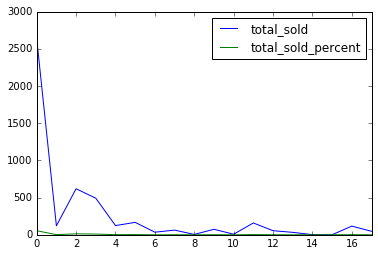

In [10]:
sold_by_genre = run_query(query)
sold_by_genre.plot()

In [11]:
query = '''
        SELECT SUM(il.quantity) total_sold, 
                g.name genre_name, 
                at.name artist_name, 
                al.title album_name
        
        FROM genre g
            INNER JOIN track t
            ON g.genre_id = t.genre_id
            INNER JOIN invoice_line il
            ON t.track_id = il.track_id
            INNER JOIN album al
            ON t.album_id = al.album_id
            INNER JOIN artist at
            ON al.artist_id = at.artist_id
            
        GROUP BY at.artist_id
        ORDER BY 1 DESC
'''

sold_by_genre_and_album = run_query(query)
sold_by_genre_and_album.head(10)

,total_sold,genre_name,artist_name,album_name
0,192,Rock,Queen,Greatest Hits I
1,187,Rock,Jimi Hendrix,Are You Experienced?
2,130,Rock,Nirvana,Nevermind
3,130,Rock,Red Hot Chili Peppers,By The Way
4,129,Rock,Pearl Jam,Vs.
5,124,Rock,AC/DC,For Those About To Rock We Salute You
6,124,Metal,Guns N' Roses,Use Your Illusion II
7,121,Rock,Foo Fighters,In Your Honor [Disc 2]
8,117,Rock,The Rolling Stones,Voodoo Lounge
9,106,Metal,Metallica,ReLoad


In [12]:
def get_recommendation(genre_name):
    top3_by_genre = sold_by_genre_and_album[sold_by_genre_and_album['genre_name']==genre_name].iloc[:3]
    return top3_by_genre

In [13]:
get_recommendation('Rock')

,total_sold,genre_name,artist_name,album_name
0,192,Rock,Queen,Greatest Hits I
1,187,Rock,Jimi Hendrix,Are You Experienced?
2,130,Rock,Nirvana,Nevermind


In [14]:
get_recommendation('Metal')

,total_sold,genre_name,artist_name,album_name
6,124,Metal,Guns N' Roses,Use Your Illusion II
9,106,Metal,Metallica,ReLoad
13,96,Metal,Godsmack,Faceless


## Analyzing Employees Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.<br>

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

* Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
* Create a plot of the results of your query.
* Write a short statement describing your results, and providing a possible interpretation.

In [15]:
query = '''
        SELECT e.first_name || " " || e.last_name agent_name,
                e.title,
                e.hire_date,
                e.country,
                SUM(i.total)
        
        FROM employee e
            INNER JOIN customer c
            ON e.employee_id = c.support_rep_id
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
        
        GROUP BY e.employee_id
'''
run_query(query)

,agent_name,title,hire_date,country,SUM(i.total)
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,Canada,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,Canada,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,Canada,1393.92


In [16]:
agent_name = '"Steve Johnson"'
q = '''
        SELECT e.first_name || " " || e.last_name agent_name,
                *
        
        FROM employee e
            INNER JOIN customer c
            ON e.employee_id = c.support_rep_id
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
            INNER JOIN invoice_line il
            ON i.invoice_id = il.invoice_id
            INNER JOIN track t
            ON il.track_id = t.track_id
            INNER JOIN media_type mt
            ON t.media_type_id = mt.media_type_id
            INNER JOIN genre g
            ON t.genre_id = g.genre_id
            INNER JOIN album al
            ON t.album_id = al.album_id
            INNER JOIN artist at
            ON al.artist_id = at.artist_id
        
        WHERE agent_name =
        '''+agent_name

run_query(q).head()

,agent_name,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,...,unit_price,media_type_id,name,genre_id,name,album_id,title,artist_id,artist_id,name
0,Steve Johnson,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,...,0.99,1,MPEG audio file,12,Easy Listening,83,My Way: The Best Of Frank Sinatra [Disc 1],85,85,Frank Sinatra
1,Steve Johnson,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,...,0.99,1,MPEG audio file,1,Rock,5,Big Ones,3,3,Aerosmith
2,Steve Johnson,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,...,0.99,1,MPEG audio file,1,Rock,215,The Police Greatest Hits,141,141,The Police
3,Steve Johnson,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,...,0.99,2,Protected AAC audio file,1,Rock,257,20th Century Masters - The Millennium Collecti...,179,179,Scorpions
4,Steve Johnson,5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,...,0.99,1,MPEG audio file,4,Alternative & Punk,42,Minha História,57,57,Os Mutantes


In [17]:
def get_performance_report(agent_name):
    
    assert agent_name in ['Jane Peacock', 'Margaret Park', 'Steve Johnson']
    
    agent_name = '"'+agent_name+'"'
    
    # create total base dataframe (relevant to the agent input)
    q = '''
        SELECT e.employee_id,
                e.first_name || " " || e.last_name agent_name,
                e.title agent_title,
                e.hire_date agent_hire_date,
                c.customer_id,
                c.first_name || " " || c.last_name customer_name,
                c.country customer_country,
                i.invoice_id,
                i.invoice_date,
                i.total payment,
                il.invoice_line_id,
                il.quantity,
                mt.name media_type_name,
                g.name genre_name,
                al.title album_title,
                at.name artist_name
                
        
        FROM employee e
            INNER JOIN customer c
            ON e.employee_id = c.support_rep_id
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
            INNER JOIN invoice_line il
            ON i.invoice_id = il.invoice_id
            INNER JOIN track t
            ON il.track_id = t.track_id
            INNER JOIN media_type mt
            ON t.media_type_id = mt.media_type_id
            INNER JOIN genre g
            ON t.genre_id = g.genre_id
            INNER JOIN album al
            ON t.album_id = al.album_id
            INNER JOIN artist at
            ON al.artist_id = at.artist_id
        
        WHERE agent_name =
        '''+agent_name
        
    base_df = run_query(q)
    #return base_df
    
    # from the selected dataframe ...
    
    def make_top3_freq_df(column_name):
        
        item_freq = base_df[column_name].value_counts()
        item_list = item_freq.index
        item_freq_perc = item_freq * 100 / item_freq.sum()
        
        item_map = {column_name:item_list,
                   column_name+'freq':item_freq,
                   column_name+'freq_perc':item_freq_perc}
        item_df = pd.DataFrame(item_map)
        item_df_top3 = item_df.iloc[:3].reset_index().drop(['index'],axis=1)
        
        return item_df_top3
    
    ## ranking: country
    customer_country_df_top3 = make_top3_freq_df('customer_country')
    
    ## ranking: genre
    genre_df_top3 = make_top3_freq_df('genre_name')

    ## ranking: artist
    artist_df_top3 = make_top3_freq_df('artist_name')

    ## ranking: media type
    media_type_df_top3 = make_top3_freq_df('media_type_name')
    
    ## ranking: VIP customer
    customer_list = base_df['customer_name'].unique()
    customer_payment_list = [base_df[base_df['customer_name']==customer]['payment'].sum()\
                             for customer in customer_list]
    
    customer_map = {'customer_name':customer_list,
                   'customer_payment':customer_payment_list}
    
    customer_df = pd.DataFrame(customer_map)
    customer_df['customer_payment_perc'] = customer_df['customer_payment']*100/customer_df['customer_payment'].sum()
    customer_df = customer_df.sort_values(by='customer_payment', ascending=False)
    customer_df_top3 = customer_df.iloc[:3].reset_index().drop(['index'],axis=1)
    
    # adding up the results above and return the dataframe(s).
    
    report_df = pd.concat([customer_country_df_top3,
                          genre_df_top3,
                          artist_df_top3,
                          media_type_df_top3,
                          customer_df_top3],
                         axis = 1)
    return report_df
    

In [18]:
get_performance_report('Jane Peacock')

,customer_country,customer_countryfreq,customer_countryfreq_perc,genre_name,genre_namefreq,genre_namefreq_perc,artist_name,artist_namefreq,artist_namefreq_perc,media_type_name,media_type_namefreq,media_type_namefreq_perc,customer_name,customer_payment,customer_payment_perc
0,Canada,377,21.555174,Rock,1046,59.805603,Queen,107,6.117782,MPEG audio file,1582,90.451687,Hugh O'Reilly,1433.52,7.856329
1,USA,207,11.835334,Metal,234,13.379074,Jimi Hendrix,80,4.574042,Protected AAC audio file,148,8.461978,François Tremblay,1367.19,7.492811
2,Brazil,193,11.034877,Alternative & Punk,154,8.805031,The Cult,49,2.801601,Purchased AAC audio file,12,0.686106,Wyatt Girard,1248.39,6.841734


In [19]:
get_performance_report('Margaret Park')

,customer_country,customer_countryfreq,customer_countryfreq_perc,genre_name,genre_namefreq,genre_namefreq_perc,artist_name,artist_namefreq,artist_namefreq_perc,media_type_name,media_type_namefreq,media_type_namefreq_perc,customer_name,customer_payment,customer_payment_perc
0,USA,503,31.4375,Rock,785,49.0625,Foo Fighters,57,3.5625,MPEG audio file,1410,88.1250,František Wichterlová,1683.00,10.569510
1,Portugal,187,11.6875,Metal,225,14.0625,Green Day,53,3.3125,Protected AAC audio file,170,10.6250,João Fernandes,1144.44,7.187267
2,Brazil,169,10.5625,Alternative & Punk,169,10.5625,Eric Clapton,51,3.1875,Purchased AAC audio file,13,0.8125,Fernanda Ramos,1025.64,6.441184


In [21]:
get_performance_report('Steve Johnson')

,customer_country,customer_countryfreq,customer_countryfreq_perc,genre_name,genre_namefreq,genre_namefreq_perc,artist_name,artist_namefreq,artist_namefreq_perc,media_type_name,media_type_namefreq,media_type_namefreq_perc,customer_name,customer_payment,customer_payment_perc
0,USA,341,24.218750,Rock,804,57.102273,Jimi Hendrix,70,4.971591,MPEG audio file,1267,89.985795,Helena Holý,1500.84,11.256311
1,Germany,169,12.002841,Alternative & Punk,169,12.002841,The Rolling Stones,59,4.190341,Protected AAC audio file,121,8.593750,Enrique Muñoz,1076.13,8.070983
2,Czech Republic,130,9.232955,Metal,160,11.363636,Pearl Jam,57,4.048295,Purchased AAC audio file,10,0.710227,Luis Rojas,912.78,6.845857


## Analyzing Sales by Country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.<br>

In particular, you have been directed to calculate data, for each country, on the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. You can use the following 'trick' to force the ordering of "Other" to last in your analysis.<br>

If there is a particular value that you would like to force to the top or bottom of results, you can put your what would normally be your most outer query in a subquery with a case statement that adds a numeric column, and then in the outer query sort by that column. Here's an example - let's start by creating a view so we're working with a manageable number of rows:

```python
c = '''
CREATE VIEW top_5_names AS
     SELECT
         first_name,
         count(customer_id) count
     FROM customer
     GROUP by 1
     ORDER by 2 DESC
     LIMIT 5;
'''
run_command(c)

q = 'SELECT * FROM top_5_names;'
run_query(q)
```

 |first_name|count
---|---|---
0|Frank|2
1|Mark|2
2|Aaron|1
3|Alexandre|1
4|Astrid|1

Next, inside a subquery, we'll select all values from our view and add a sorting column using a case statement, before sorting using that new column in the outer query.

```python
q = '''
SELECT
    first_name,
    count
FROM
    (
    SELECT
        t5.*,
        CASE
            WHEN t5.first_name = "Mark" THEN 1
            ELSE 0
        END AS sort
    FROM top_5_names t5
   )
ORDER BY sort ASC
'''
run_query(q)
```

 |first_name|count
---|---|---
0|Frank|2
1|Aaron|1
2|Alexandre|1
3|Astrid|1
4|Mark|2

You should be able to adapt this technique into your query to force 'Other' to the bottom of your results. When working through this exercise, you will need multiple subqueries and joins. Imagine you work on a team of data analysts, and write your query so that it will be able to be easily read and understood by your colleagues.<br>

In the next screen we'll create some visualizations and interpret the data - for now we'll just write our query.

* Write a query that collates data on purchases from different countries. For each country, include:
  * total number of customers
  * total value of sales
  * average value of sales per customer
  * average order value
* Where a country has only one customer, collect them into an "Other" group.
* The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [22]:
test_q = '''
        WITH test_c AS (
        SELECT c.customer_id,
                c.first_name,
                c.last_name,
                c.country,
                SUM(i.total) as total
        FROM customer c
        INNER JOIN invoice i
        On c.customer_id = i.customer_id
        GROUP BY c.country, c.customer_id)
        
        SELECT AVG(total), country
        FROM test_c
        GROUP BY country
'''
run_query(test_q)

,AVG(total),country
0,39.600000,Argentina
1,81.180000,Australia
2,69.300000,Austria
3,60.390000,Belgium
4,85.536000,Brazil
5,66.948750,Canada
6,97.020000,Chile
7,136.620000,Czech Republic
8,37.620000,Denmark
9,79.200000,Finland


In [23]:
q = '''
    WITH 
        customer_invoice AS (
            SELECT c.customer_id,
                    c.country,
                    i.total
            FROM customer c
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
        ),
        
        customer_basic_info_by_country AS (
            SELECT country,
                    SUM(customer_id) total_customers,
                    SUM(total) total_sales,
                    AVG(total) average_order_value
    
            FROM customer_invoice
            GROUP BY country
        ),
        
        customer_avg_payment_by_country AS (
            
            WITH customer_invoice_groupby AS (
            SELECT c.customer_id,
                    c.country,
                    SUM(i.total) as total
            FROM customer c
            INNER JOIN invoice i
            On c.customer_id = i.customer_id
            GROUP BY c.country, c.customer_id
            )

            SELECT AVG(total) avg_sales_per_customer, country
            FROM customer_invoice_groupby
            GROUP BY country
        )
        
    SELECT basic.country,
            basic.total_customers,
            basic.total_sales,
            avg_pay.avg_sales_per_customer,
            basic.average_order_value
    
    FROM customer_basic_info_by_country basic
    INNER JOIN customer_avg_payment_by_country avg_pay
    ON basic.country = avg_pay.country
    ORDER BY 3 DESC

'''

run_query(q)

,country,total_customers,total_sales,avg_sales_per_customer,average_order_value
0,USA,2889,1040.49,80.037692,7.942672
1,Canada,1801,535.59,66.948750,7.047237
2,Brazil,570,427.68,85.536000,7.011148
3,France,2058,389.07,77.814000,7.781400
4,Germany,1130,334.62,83.655000,8.161463
5,Czech Republic,162,273.24,136.620000,9.108000
6,United Kingdom,1485,245.52,81.840000,8.768571
7,Portugal,1002,185.13,92.565000,6.383793
8,India,1226,183.15,91.575000,8.721429
9,Ireland,598,114.84,114.840000,8.833846


In [24]:
# add one more condition to categorize minor countries
# Since there is no country having only one customer,
# we can check the codes working by setting condition
# as total customers less than 50 or 100.

q = '''
    WITH 
        customer_invoice AS (
            SELECT c.customer_id,
                    c.country,
                    i.total
            FROM customer c
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
        ),
        
        customer_basic_info_by_country AS (
            SELECT country,
                    SUM(customer_id) total_customers,
                    SUM(total) total_sales,
                    AVG(total) average_order_value
    
            FROM customer_invoice
            GROUP BY country
        ),
        
        customer_avg_payment_by_country AS (
            
            WITH customer_invoice_groupby AS (
            SELECT c.customer_id,
                    c.country,
                    SUM(i.total) as total
            FROM customer c
            INNER JOIN invoice i
            On c.customer_id = i.customer_id
            GROUP BY c.country, c.customer_id
            )

            SELECT AVG(total) avg_sales_per_customer, country
            FROM customer_invoice_groupby
            GROUP BY country
        )
        
    SELECT 
            CASE
                WHEN basic.total_customers < 100 THEN "Other"
                ELSE basic.country
                END AS country,
            basic.country as original_country,
            basic.total_customers,
            basic.total_sales,
            avg_pay.avg_sales_per_customer,
            basic.average_order_value,
            CASE
                WHEN basic.total_customers < 100 THEN 1
                ELSE 0
                END AS sort
    
    FROM customer_basic_info_by_country basic
    INNER JOIN customer_avg_payment_by_country avg_pay
    ON basic.country = avg_pay.country
    ORDER BY sort, 3 DESC

'''

run_query(q)

,country,original_country,total_customers,total_sales,avg_sales_per_customer,average_order_value,sort
0,USA,USA,2889,1040.49,80.037692,7.942672,0
1,France,France,2058,389.07,77.814000,7.781400,0
2,Canada,Canada,1801,535.59,66.948750,7.047237,0
3,United Kingdom,United Kingdom,1485,245.52,81.840000,8.768571,0
4,India,India,1226,183.15,91.575000,8.721429,0
5,Germany,Germany,1130,334.62,83.655000,8.161463,0
6,Portugal,Portugal,1002,185.13,92.565000,6.383793,0
7,Chile,Chile,741,97.02,97.020000,7.463077,0
8,Ireland,Ireland,598,114.84,114.840000,8.833846,0
9,Brazil,Brazil,570,427.68,85.536000,7.011148,0


In [25]:
# finally, we grab the values in 'Other' countries into one column
# using GROUPBY once again.

q = '''
    WITH 
        customer_invoice AS (
            SELECT c.customer_id,
                    c.country,
                    i.total
            FROM customer c
            INNER JOIN invoice i
            ON c.customer_id = i.customer_id
        ),
        
        customer_basic_info_by_country AS (
            SELECT country,
                    SUM(customer_id) total_customers,
                    SUM(total) total_sales,
                    AVG(total) average_order_value
    
            FROM customer_invoice
            GROUP BY country
        ),
        
        customer_avg_payment_by_country AS (
            
            WITH customer_invoice_groupby AS (
            SELECT c.customer_id,
                    c.country,
                    SUM(i.total) as total
            FROM customer c
            INNER JOIN invoice i
            On c.customer_id = i.customer_id
            GROUP BY c.country, c.customer_id
            )

            SELECT AVG(total) avg_sales_per_customer, country
            FROM customer_invoice_groupby
            GROUP BY country
        ),
        
        customer_sales_overview_raw AS (
        
            SELECT 
            CASE
                WHEN basic.total_customers < 100 THEN "Other"
                ELSE basic.country
                END AS country,
            basic.total_customers,
            basic.total_sales,
            avg_pay.avg_sales_per_customer,
            basic.average_order_value,
            CASE
                WHEN basic.total_customers < 100 THEN 1
                ELSE 0
                END AS sort
    
            FROM customer_basic_info_by_country basic
            INNER JOIN customer_avg_payment_by_country avg_pay
            ON basic.country = avg_pay.country
            ORDER BY sort, 3 DESC
        )
        
        SELECT country,
                SUM(total_customers) total_customers,
                SUM(total_sales) total_sales,
                AVG(avg_sales_per_customer) avg_sales_per_customer,
                AVG(average_order_value) average_order_value
        
        FROM customer_sales_overview_raw
        GROUP BY country
        ORDER BY sort, SUM(total_sales) DESC

'''

run_query(q)

,country,total_customers,total_sales,avg_sales_per_customer,average_order_value
0,USA,2889,1040.49,80.037692,7.942672
1,Canada,1801,535.59,66.948750,7.047237
2,Brazil,570,427.68,85.536000,7.011148
3,France,2058,389.07,77.814000,7.781400
4,Germany,1130,334.62,83.655000,8.161463
5,Czech Republic,162,273.24,136.620000,9.108000
6,United Kingdom,1485,245.52,81.840000,8.768571
7,Portugal,1002,185.13,92.565000,6.383793
8,India,1226,183.15,91.575000,8.721429
9,Ireland,598,114.84,114.840000,8.833846


## Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.<br>

When we're working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, we should create different plots for each dimension.<br>

Think about the best way to communicate the data - this includes not only plot types, but how you use color, spacing and layout. As an example, you might decide to use the same color across your four plots to represent each country, so it's easier to understand the chart as a whole.<br>

You might like to review our [Storytelling Through Data Visualization](https://www.dataquest.io/course/storytelling-data-visualization) course to re-familiarize yourself with some of these techniques.

* For each dimension, create a visualization which demonstrates the data we collated in the previous step.
  * You should decide whether the "Other" group is relevant to your analysis and make decisions on where to include it (if anywhere) in your visualizations.
* Write a few sentences interpreting your data and visualizations, and make one or more recommendations to the marketing team on which countries have potential for growth.

In [26]:
customer_sales_overview_by_country = run_query(q)
customer_sales_overview_by_country.head()

,country,total_customers,total_sales,avg_sales_per_customer,average_order_value
0,USA,2889,1040.49,80.037692,7.942672
1,Canada,1801,535.59,66.948750,7.047237
2,Brazil,570,427.68,85.536000,7.011148
3,France,2058,389.07,77.814000,7.781400
4,Germany,1130,334.62,83.655000,8.161463


In [27]:
customer_sales_overview_by_country.index = customer_sales_overview_by_country['country']

In [28]:
customer_sales_overview_by_country_T = customer_sales_overview_by_country.drop(['country'], axis=1).T
customer_sales_overview_by_country_T.head()

country,USA,Canada,Brazil,France,Germany,Czech Republic,United Kingdom,Portugal,India,Ireland,...,Chile,Australia,Finland,Hungary,Poland,Sweden,Netherlands,Italy,Argentina,Other
total_customers,2889.000000,1801.000000,570.000000,2058.0000,1130.000000,162.000,1485.000000,1002.000000,1226.000000,598.000000,...,741.000000,550.000,484.0,450.000,490.000,510.000,480.000,423.00,280.00,245.000000
total_sales,1040.490000,535.590000,427.680000,389.0700,334.620000,273.240,245.520000,185.130000,183.150000,114.840000,...,97.020000,81.180,79.2,78.210,76.230,75.240,65.340,50.49,39.60,239.580000
avg_sales_per_customer,80.037692,66.948750,85.536000,77.8140,83.655000,136.620,81.840000,92.565000,91.575000,114.840000,...,97.020000,81.180,79.2,78.210,76.230,75.240,65.340,50.49,39.60,59.895000
average_order_value,7.942672,7.047237,7.011148,7.7814,8.161463,9.108,8.768571,6.383793,8.721429,8.833846,...,7.463077,8.118,7.2,7.821,7.623,7.524,6.534,5.61,7.92,7.029786


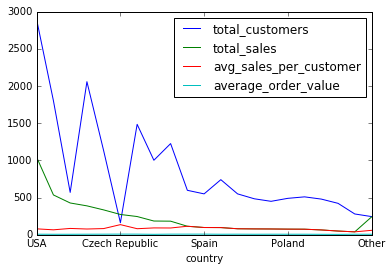

In [29]:
plt.figure(figsize=(30, 30))
customer_sales_overview_by_country.plot()
plt.show()

### Hard to compare : different scales for each performance index
* need to scale each performance index column in dataframe.

In [30]:
# re-define
customer_sales_overview_by_country = run_query(q)

In [31]:
customer_sales_overview_by_country.head()

,country,total_customers,total_sales,avg_sales_per_customer,average_order_value
0,USA,2889,1040.49,80.037692,7.942672
1,Canada,1801,535.59,66.948750,7.047237
2,Brazil,570,427.68,85.536000,7.011148
3,France,2058,389.07,77.814000,7.781400
4,Germany,1130,334.62,83.655000,8.161463


In [32]:
def scale_column(column):
    return (column - column.mean())/column.std()

scaled_nums = customer_sales_overview_by_country.iloc[:, 1:].apply(scale_column, axis=0)
customer_sales_overview_by_country_scaled = pd.concat([customer_sales_overview_by_country['country'],
                                               scaled_nums],
                                              axis=1)

customer_sales_overview_by_country_scaled.index = customer_sales_overview_by_country_scaled['country']
customer_sales_overview_by_country_scaled.drop(['country'], axis=1, inplace=True)

customer_sales_overview_by_country_scaled.head()

,total_customers,total_sales,avg_sales_per_customer,average_order_value
country,,,,
USA,2.936447,3.495063,-0.071050,0.276298
Canada,1.359483,1.333106,-0.699920,-0.707020
Brazil,-0.424748,0.871041,0.193120,-0.746652
France,1.731983,0.705715,-0.177890,0.099198
Germany,0.386925,0.472562,0.102746,0.516563


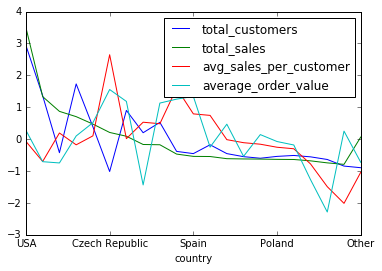

In [33]:
customer_sales_overview_by_country_scaled.plot()

### To see the potential itself from each market,
* we need to focus on **`average`** type of performance index

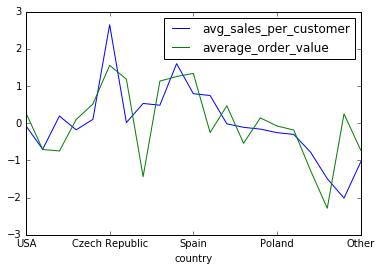

In [34]:
customer_sales_overview_by_country_scaled[['avg_sales_per_customer',
                                          'average_order_value']].plot()

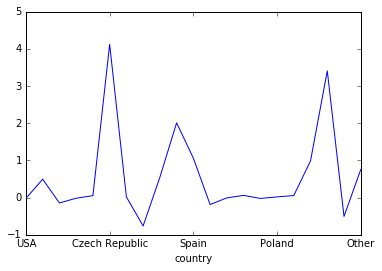

In [35]:
# make new column and plot

customer_sales_overview_by_country_scaled['avg_index'] = customer_sales_overview_by_country_scaled['avg_sales_per_customer']\
                                                        * customer_sales_overview_by_country_scaled['average_order_value']
customer_sales_overview_by_country_scaled['avg_index'].plot()    

### Top 3 Countries with the highest `avg` performance index

In [36]:
customer_sales_overview_by_country_scaled['avg_index'].sort_values(ascending=False)[:5]

country
Czech Republic    4.119498
Italy             3.406708
Ireland           2.009225
Spain             1.060739
Netherlands       0.987550
Name: avg_index, dtype: float64

## Suggestion to Marketing Team
* Even if USA and Canada are major countries in perspective with total sales,
* In terms of individual customer's royalty to our company, we can see 3 countries showing distictive performance indices.
  * Therefore, we recommend to **execute some marketing plans to raise the individual customer's royalty** in the countries below:
  * **`Czech Republic`, `Italy`, `Ireland`**

## Albums vs Individual Tracks, Part 1

The Chinook store allows customers to either purchase a whole album, or to purchase one or more individual tracks.<br>

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.<br>

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to make their decision.<br>

In order to answer this question, 
* we're going to have to identify whether each invoice has all the tracks from an album. 
  * We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. 
  * We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. 
  * It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

Up until now, we've only ever compared two single values, using operators like `=` `!=` and `LIKE`. 

### To compare two tables of value, we can use the `EXCEPT` operator that we learned in the previous mission.

Let's say we had three tables in a database, as shown in the diagram below

![https://s3.amazonaws.com/dq-content/191/test_tables.svg](https://s3.amazonaws.com/dq-content/191/test_tables.svg)

We want to find a way to compare the `letters` columns from `test_table_2` and `test_table_3` to `test_table_1` to see if they are contain all of the same values as `test_table_1`. Let's use `EXCEPT` and see what we get with the first two tables:

![https://s3.amazonaws.com/dq-content/191/compare_example_1.svg](https://s3.amazonaws.com/dq-content/191/compare_example_1.svg)

Here's the table that is returned:

|letters|
|---|
|D|

Now, let's compare what we get with `test_table_1` and `test_table_3`:

![https://s3.amazonaws.com/dq-content/191/compare_example_2.svg](https://s3.amazonaws.com/dq-content/191/compare_example_2.svg)

If you run this directly in SQLite, you will get no result at all. That's because the exception of two identical tables is nothing (technically, `NULL`). This is useful to us - we can check whether the exception of two subqueries `IS NULL` to work out if our two lists of tracks are identical.<br>

Once we've made the comparison, we can wrap it in a case statement to add a column that tells us if that invoice was an album purchase or not.<br>

You should be careful with the order of your the statements either side of the `EXCEPT` operator. If we were to execute the below we would get a null value:

![https://s3.amazonaws.com/dq-content/191/compare_example_3.svg](https://s3.amazonaws.com/dq-content/191/compare_example_3.svg)

That's because all of the values for letter in `test_table_2` are also in `test_table_1`, even if `test_table_1` has an extra value. Make sure you get the order right, otherwise you may end up incorrect results.<br>

You should have everything you need to collate data on album vs single track purchases. This is easily the hardest query you have written so far, so take your time, and remember the tips from the first screen!


* Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
  * Number of invoices
  * Percentage of invoices

In [127]:
query = '''
        WITH 
        base_table AS
            (
                SELECT i.invoice_id,
                        il.invoice_line_id,
                        il.track_id,
                        t.album_id
                
                FROM invoice i
                INNER jOIN invoice_line il
                    ON i.invoice_id = il.invoice_id
                INNER jOIN track t
                    ON il.track_id = t.track_id
                INNER JOIN album a
                    ON t.album_id = a.album_id
            ),
            
        tracks_by_album AS
            (
                SELECT t.track_id,
                        a.album_id
                
                FROM track t
                INNER JOIN album a
                    ON t.album_id = a.album_id
                
                ORDER BY 2
            ),
            
        tracks_by_album_with_ids AS
            (
                SELECT album_id,
                        COUNT(track_id) num_tracks, 
                        GROUP_CONCAT(track_id) track_ids
                        
                FROM tracks_by_album
                GROUP BY album_id
            ),
            
        combined AS
            (
                SELECT base_table.invoice_id,
                        base_table.track_id,
                        base_table.album_id,
                        unique_record.unique_track_num,
                        unique_record.unique_album_num

                FROM 

                (SELECT invoice_id,
                        COUNT(DISTINCT(track_id)) unique_track_num,
                        COUNT(DISTINCT(album_id)) unique_album_num
                FROM base_table
                GROUP BY 1) unique_record

                INNER JOIN base_table

                ON unique_record.invoice_id = base_table.invoice_id
            ),
            
        combined_with_ids AS
            (
                SELECT invoice_id,
                        album_id,
                        GROUP_CONCAT(track_id) track_ids
                        
                FROM combined
                GROUP BY 1
            )
        
        SELECT album_id, track_ids
        FROM combined_with_ids
        
'''

run_query(query)

,album_id,track_ids
0,91,"1158,1159,1160,1161,1162,1163,1164,1165,1166,1..."
1,215,"3476,482,2701,1641,1119,2324,201,819,392,2651"
2,214,"2516,2646"
3,203,"3448,2560,3336,829,1872,748,1778,2514"
4,163,"1986,1987,1988,1989,1990,1991,1992,1993,1994,1..."
5,5,"1045,30"
6,6,"3477,3439,1102,711,1988,3024,834,2596,1343,264..."
7,125,"2231,2509,81,1758,1455,2946,574,1752,2263,1560"
8,20,"206,3456,1041,1279,2098,3399,1983,993,196"
9,257,"2663,3290"


In [131]:
q = '''WITH final_table AS 
        ( WITH new_table AS 
            ( SELECT * FROM 
                ( 
                SELECT a.album_id album_ID,
                        COUNT(t.track_id) in_num_tra,
                        il.invoice_id 
                FROM album a 
                INNER JOIN track t 
                    ON a.album_id = t.album_id 
                INNER JOIN invoice_line il 
                    ON il.track_id = t.track_id 
                            
                GROUP BY 1,3 ) t1 
            
                LEFT JOIN (
                    SELECT a.album_id ID,
                            COUNT(t.track_id) num_tracks 
                    FROM album a
                        INNER JOIN track t 
                        ON t.album_id = a.album_id 
                        GROUP BY 1 ) t2
                        
                ON t2.ID = t1.album_ID 
            )
        )
                            
        SELECT 
            CASE 
                WHEN in_num_tra = num_tracks 
                    THEN 'yes' 
                ELSE 'no' 
                END AS 'yes_no', 
            * 

            FROM new_table 
                    
        SELECT COUNT(invoice_id), 
                yes_no 
        FROM final_table 
        GROUP BY yes_no;
''' 
run_query(q)

DatabaseError: Execution failed on sql 'WITH final_table AS 
        ( WITH new_table AS 
            ( SELECT * FROM 
                ( SELECT a.album_id album_ID,
                        COUNT(t.track_id) in_num_tra,
                        il.invoice_id 
                        FROM album a 
                        INNER JOIN track t 
                            ON a.album_id = t.album_id 
                        INNER JOIN invoice_line il 
                            ON il.track_id = t.track_id 
                            
                    GROUP BY 1,3 ) t1 
                    LEFT JOIN ( 
                        SELECT a.album_id ID,
                        COUNT(t.track_id) num_tracks 
                        FROM album a 
                            INNER JOIN track t 
                            ON t.album_id = a.album_id 
                            GROUP BY 1 ) t2 
                        ON t2.ID = t1.album_ID 
            )
        )
                            
                    SELECT 
                        CASE 
                            WHEN in_num_tra = num_tracks 
                                THEN 'yes' 
                            ELSE 'no' 
                            END AS 'yes_no', 
                        * 
                        
                        FROM new_table 
                    
        SELECT COUNT(invoice_id), 
                yes_no 
        FROM final_table 
        GROUP BY yes_no;
': near ")": syntax error

In [102]:
query = '''
        WITH 
        base_table AS
            (
                SELECT i.invoice_id,
                        il.invoice_line_id,
                        il.track_id,
                        t.album_id
                
                FROM invoice i
                INNER jOIN invoice_line il
                    ON i.invoice_id = il.invoice_id
                INNER jOIN track t
                    ON il.track_id = t.track_id
                INNER JOIN album a
                    ON t.album_id = a.album_id
            ),
            
        tracks_by_album AS
            (
                SELECT t.track_id,
                        a.album_id
                
                FROM track t
                INNER JOIN album a
                    ON t.album_id = a.album_id
                
                ORDER BY 2
            ),
            
        tracks_num_by_album AS
            (
                SELECT album_id, COUNT(track_id) tracks_num
                FROM tracks_by_album
                GROUP BY album_id
            ),
            
        combined AS
            (
                SELECT base_table.invoice_id,
                        base_table.track_id,
                        base_table.album_id,
                        unique_record.unique_track_num,
                        unique_record.unique_album_num

                FROM 

                (SELECT invoice_id,
                        COUNT(DISTINCT(track_id)) unique_track_num,
                        COUNT(DISTINCT(album_id)) unique_album_num
                FROM base_table
                GROUP BY 1) unique_record

                INNER JOIN base_table

                ON unique_record.invoice_id = base_table.invoice_id
            ),
            
        album_purchase AS
            (
                SELECT DISTINCT(c.invoice_id),
                        c.album_id
        
                FROM tracks_num_by_album tnba
                INNER JOIN combined c
                ON tnba.album_id = c.album_id
                WHERE (unique_album_num = 1)
                    AND (tracks_num = unique_track_num)
            )
        
        SELECT
            CASE
                WHEN (
                    (SELECT
                    
                    )
                    
                    EXCEPT
                    
                    (SELECT
                    
                    )
                
                ) IS NULL THEN 1
                
                ELSE 0
            
            END AS is_album_purchase
        
        FROM tracks_by_album tba
        LEFT JOIN combined c
            ON tba.album_id = c.album_id
        
'''

run_query(query)

,track_id,album_id,invoice_id,track_id,album_id,unique_track_num,unique_album_num
0,1,1,21.0,13.0,1.0,9.0,8.0
1,1,1,23.0,1.0,1.0,10.0,1.0
2,1,1,23.0,6.0,1.0,10.0,1.0
3,1,1,23.0,7.0,1.0,10.0,1.0
4,1,1,23.0,8.0,1.0,10.0,1.0
5,1,1,23.0,9.0,1.0,10.0,1.0
6,1,1,23.0,10.0,1.0,10.0,1.0
7,1,1,23.0,11.0,1.0,10.0,1.0
8,1,1,23.0,12.0,1.0,10.0,1.0
9,1,1,23.0,13.0,1.0,10.0,1.0
